Sufficient decrease failed with alpha =  1.00000000e+00
phi(alpha) =                             3.19000000e+03
phi0 + c1*alpha*dphi0 =                 -2.10000000e-01


1.0

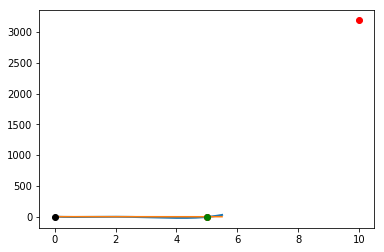

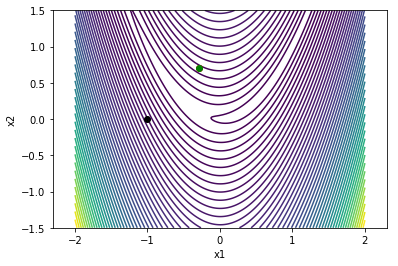

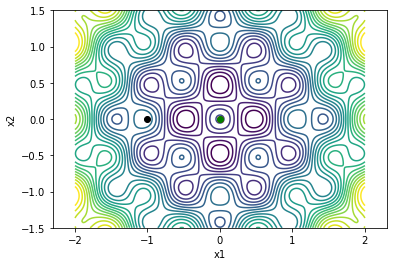

In [51]:
import numpy as np
import matplotlib.pylab as plt

def fonedim(x, linesearch=False, symb='ko'):
    f = -x[0] + x[0]*(x[0] - 5)*(2 - x[0])**2
    if linesearch:
        plt.plot(x[0], f, symb)
    return f

def fonedim_grad(x):
    return np.array([-21 + 48*x[0] - 27*x[0]**2 + 4*x[0]**3])
    
def rosen(x, linesearch=False, symb='ko'):
    '''If the linesearch flag is true, plot the point'''
    if linesearch:
        plt.plot([x[0]], [x[1]], symb)
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

def rosen_grad(x):
    return np.array([-2*(1 - x[0]) - 200*(x[1] - x[0]**2)*x[0], 
                      200*(x[1] - x[0]**2) ])

def griewank(x, linesearch=False, symb='ko'):
    if linesearch:
        plt.plot([x[0]], [x[1]], symb)
    return x[0]**2 + x[1]**2 + np.cos(2*np.pi*x[0])*np.cos(2*np.pi*x[1])

def griewank_grad(x):
    return np.array([2*x[0] - 2*np.pi*np.sin(2*np.pi*x[0])*np.cos(2*np.pi*x[1]),
                     2*x[1] - 2*np.pi*np.cos(2*np.pi*x[0])*np.sin(2*np.pi*x[1])])

def onedim_plot(func, n=250, xhigh=5.0):
    x = np.linspace(0, xhigh, n)
    f = np.zeros(n)
    for i in range(n):
        f[i] = func([x[i]])
    plt.figure()
    plt.plot(x, f, linewidth=2)
    return

def contour_plot(func, n=250, xlow=-2, xhigh=2, ylow=-1.5, yhigh=1.5):
    '''Create a contour plot of the function'''
    x = np.linspace(xlow, xhigh, n)
    y = np.linspace(ylow, yhigh, n)
    X, Y = np.meshgrid(x, y)
    f = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            f[i, j] = func([X[i, j], Y[i, j]])

    plt.figure()
    if func == rosen:
        plt.contour(X, Y, f, levels=np.max(f)*np.linspace(0, 1.0, 50)**2)
    else:
        plt.contour(X, Y, f, levels=np.linspace(np.min(f), np.max(f), 25))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')    
    return
    
def backtrack(func, grad_func, x, p, 
              tau=0.5, alpha=1.0, c1=1e-3, max_iter=100):
    '''
    Given the function pointer and the gradient function pointer,
    find a step length alpha that satisfies the sufficient decrease
    conditions.
    '''
    
    # Evaluate the function and gradient at the initial point x
    phi0 = func(x, linesearch=True)
    grad0 = grad_func(x)
    
    # Compute the derivative of the merit function at alpha = 0.0
    dphi0 = np.dot(grad0, p)
    
    # Check for a descent direction
    if dphi0 >= 0.0:
        return ValueError('Must provide a descent direction')
    
    for i in range(max_iter):
        # Evaluate the function at the new point
        xp = x + alpha*p
        phi = func(xp, linesearch=True, symb='ro')
        
        # Check the sufficient decrease condition
        if phi < phi0 + c1*alpha*dphi0:
            # Evaluate the function again to illustrate the final point
            func(xp, linesearch=True, symb='go')
            return alpha
        else:
            print 'Sufficient decrease failed with alpha = %15.8e'%(alpha)
            print 'phi(alpha) =                            %15.8e'%(phi)
            print 'phi0 + c1*alpha*dphi0 =                 %15.8e'%(phi0 + c1*alpha*dphi0)
        
        # Set the alpha values and append one to the list
        alpha = tau*alpha
    
    # The line search has failed at this point
    return 0.0

# Plot the one dimensional problem
x = np.array([0])
p = np.array([10])
onedim_plot(fonedim, xhigh=5.5)

# Plot the sufficient decrease line
phi0 = fonedim(x)
dphi0 = np.dot(fonedim_grad(x), p)
xhigh = 5.5
alph = p[0]
c1 = 0.01
plt.plot([0.0, xhigh], [phi0, phi0 + c1*(xhigh/alph)*dphi0])

# Perform a backtracking line search
backtrack(fonedim, fonedim_grad, x, p)

# Create a contour plot
contour_plot(rosen)

# Choose an initial point and the gradient direction
x = np.array([-1, 0])
p = -rosen_grad(x)
p = p/np.sqrt(np.dot(p, p))

# Perform a backtracking line search
backtrack(rosen, rosen_grad, x, p)

# Create a contour plot
contour_plot(griewank)

p = -griewank_grad(x)
p = p/np.sqrt(np.dot(p, p))

# Perform a backtracking line search
backtrack(griewank, griewank_grad, x, p)


Slope condition violated; interval found
Zoom: Sufficient decrease conditions violated
Zoom: Wolfe conditions satisfied
Sufficient decrease conditions violated; interval found
Zoom: Sufficient decrease conditions violated
Zoom: Wolfe conditions satisfied


0.25

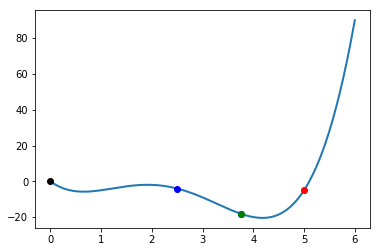

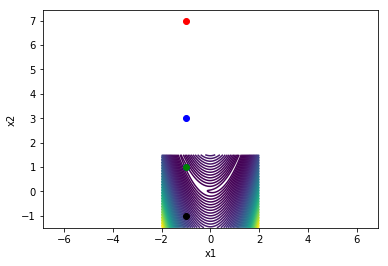

In [45]:
def strong_wolfe(func, grad_func, x, pk, c1=1e-3, c2=0.9,
                 alpha=1.0, alpha_max=100.0, max_iters=100):
    '''
    Strong Wolfe condition line search method 

    Input:
    func:      the function pointer
    grad_func: the gradien function pointer
    x:         the design variables
    p:         the search direction
    alpha:     the initial estimate for the step length
    alpha_max: the maximum value of alpha 

    returns:
    alpha:     the step length satisfying the strong Wolfe conditions
    '''
    
    # Compute the function and the gradient at alpha = 0
    fk = func(x, linesearch=True)
    gk = grad_func(x)

    # Compute the dot product of the gradient with the search
    # direction to evaluate the derivative of the merit function
    proj_gk = np.dot(gk, pk)

    # Store the old value of the objective
    fj_old = fk
    proj_gj_old = proj_gk
    alpha_old = 0.0

    for j in xrange(max_iters):
        # Evaluate the merit function
        fj = func(x + alpha*pk, linesearch=True, symb='ro')

        # Evaluate the gradient at the new point
        gj = grad_func(x + alpha*pk)
        proj_gj = np.dot(gj, pk)

        # Check if either the sufficient decrease condition is
        # violated or the objective increased
        if (fj > fk + c1*alpha*proj_gk or
            (j > 0 and fj > fj_old)):
            print 'Sufficient decrease conditions violated; interval found'
            # Zoom and return
            return zoom(func, grad_func, fj_old, proj_gj_old, alpha_old, 
                        fj, proj_gj, alpha,
                        x, fk, gk, pk, c1=c1, c2=c2)

        # Check if the strong Wolfe conditions are satisfied
        if np.fabs(proj_gj) <= c2*np.fabs(proj_gk):
            print 'Strong Wolfe alpha found directly'
            func(x + alpha*pk, linesearch=True, symb='go')
            return alpha

        # If the line search is vioalted
        if proj_gj >= 0.0:
            print 'Slope condition violated; interval found'
            return zoom(func, grad_func, fj, proj_gj, alpha, 
                        fj_old, proj_gj_old, alpha_old,
                        x, fk, gk, pk, c1=c1, c2=c2)

        # Record the old values of alpha and fj
        fj_old = fj
        proj_gj_old = proj_gj
        alpha_old = alpha

        # Pick a new value for alpha
        alpha = min(2.0*alpha, alpha_max)

        if alpha >= alpha_max:
            print 'Line search failed here'
            return None

    print 'Line search unsuccessful'
    return alpha

def zoom(func, grad_func, f_low, proj_low, alpha_low, 
         f_high, proj_high, alpha_high,
         x, fk, gk, pk, c1=1e-3, c2=0.9, max_iters=100):
    '''
    Zoom function: Locate a value between alpha_low and alpha_high
    that satisfies the strong Wolfe conditions. Remember:
    alpha_low/alpha_high are step lengths yielding the
    lowest/higher values of the merit function. 

    input:
    f_low:      the value of f(x) at alpha_low
    proj_low:   the value of the derivative of phi at alpha_low
    alpha_low:  the value of the step at alpha_low
    f_high:     the value of f(x) at alpha_high
    proj_high:  the value of the derivative of phi at alpha_high
    alpha_high: the value of the step at alpha_high
    x:          the value of the design variables at alpha = 0
    fk:         the value of the function at alpha = 0
    gk:         the gradient of the function at alpha = 0
    pk:         the line search direction

    returns:
    alpha:   a step length satisfying the strong Wolfe conditions
    '''

    proj_gk = np.dot(pk, gk)

    for j in xrange(max_iters):
        # Pick an alpha value using cubic interpolation
        # alpha_j = cubic_interp(alpha_low, f_low, proj_low,
        #                        alpha_high, f_high, proj_high)

        # Pick an alpha value by bisecting the interval
        alpha_j = 0.5*(alpha_high + alpha_low)

        # Evaluate the merit function
        fj = func(x + alpha_j*pk, linesearch=True, symb='bo')

        # Check if the sufficient decrease condition is violated
        if fj > fk + c1*alpha_j or fj >= f_low:
            print 'Zoom: Sufficient decrease conditions violated'
            alpha_high = alpha_j
            f_high = fj

            # We need the derivative here for proj_high
            gj = grad_func(x + alpha_j*pk)
            proj_high = np.dot(gj, pk)
        else:
            # Evaluate the gradient of the function and the
            # derivative of the merit function
            gj = grad_func(x + alpha_j*pk)
            proj_gj = np.dot(gj, pk)

            # Return alpha, the strong Wolfe conditions are
            # satisfied
            if np.fabs(proj_gj) <= c2*np.fabs(proj_gk):
                print 'Zoom: Wolfe conditions satisfied'
                func(x + alpha_j*pk, linesearch=True, symb='go')
                return alpha_j
            else:
                 print 'Zoom: Curvature condition violated'

            # Make sure that we have the intervals right
            if proj_gj*(alpha_high - alpha_low) >= 0.0:
                # Swap alpha high/alpha low
                alpha_high = alpha_low
                proj_high = proj_low
                f_high = f_low

            # Swap alpha low/alpha j
            alpha_low = alpha_j
            proj_low = proj_gj
            f_low = fj

    return alpha_j

def cubic_interp(self, x0, m0, dm0, x1, m1, dm1):
    '''
    Return an x in the interval (x0, x1) that minimizes a cubic
    interpolant between two points with both function and
    derivative values.

    This method does not assume that x0 > x1. If the solution is
    not in the interval, the function returns the mid-point.
    '''

    # Compute d1
    d1 = dm0 + dm1 - 3*(m0 - m1)/(x0 - x1)

    # Check that the square root will be real in the
    # expression for d2
    if (d1**2 - dm0*dm1) < 0.0:
        print 'Cubic interpolation fail'
        return 0.5*(x0 + x1)

    # Compute d2
    d2 = np.sign(x1 - x0)*np.sqrt(d1**2 - dm0*dm1)

    # Evaluate the new interpolation point
    x = x1 - (x1 - x0)*(dm1 + d2 - d1)/(dm1 - dm0 + 2*d2)

    # If the new point is outside the interval, return
    # the mid point
    if x1 > x0 and (x > x1 or x < x0):
        return 0.5*(x0 + x1)
    elif x0 > x1 and (x > x0 or x < x1):
        return 0.5*(x0 + x1)

    return x

# Plot the one dimensional problem
x = np.array([0])
p = np.array([5])
onedim_plot(fonedim, xhigh=5.5)

# Perform a backtracking line search
strong_wolfe(fonedim, fonedim_grad, x, p)

# Choose an initial point and the gradient direction
x = np.array([-1, -1])
# p = -rosen_grad(x)
# p = *p/np.sqrt(np.dot(p, p))
p = np.array([0, 8])

# Create a contour plot
contour_plot(rosen)

# Perform a backtracking line search
strong_wolfe(rosen, rosen_grad, x, p)